In [1]:
import pandas as pd
import torch
import torch.nn as nn

In [2]:
from Modules import Fingerprint_Generator

fingerprint = "ecfp"

df = pd.read_csv("Transformed_Data/DILIst_DILI.csv", index_col=0)  # Map style dataset
df = Fingerprint_Generator.generate_fp_column(df, df.drug, fp_type=fingerprint)

df_fp = pd.DataFrame(df.iloc[:, 2])
df_fp.insert(len(df_fp.columns), "DILI?", df.iloc[:, 1].astype(int))  # Insert 'DILI?' column as the last column

df_fp.to_csv("Transformed_Data/testo")

[16:12:31] WARNING: not removing hydrogen atom without neighbors
[16:12:31] WARNING: not removing hydrogen atom without neighbors


In [3]:
class DILIDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels) -> None:
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        features = self.features.iloc[index]
        labels = self.labels.iloc[index]
        return torch.tensor([features], dtype=torch.float32), torch.tensor([labels], dtype=torch.float32)
        # return torch.from_numpy(np.asarray([features])), torch.from_numpy(np.asarray([labels]))


DILIfeatures = df_fp.iloc[:, 0]
DILIlabels = df_fp.iloc[:, 1]

dataset = DILIDataset(DILIfeatures, DILIlabels)

In [4]:
torch.manual_seed(42)

BATCH_SIZE = 12

train_size = int(len(dataset) * 0.8)
validation_size = len(dataset) - train_size

train_data, validation_data = torch.utils.data.random_split(dataset, [train_size, validation_size])

if len(train_data) + len(validation_data) == len(dataset):
    print("Dataset split succeeded")
else:
    print("Dataset split failed")

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Dataset split succeeded


In [5]:
# Set the device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device: {torch.cuda.get_device_name(0)}")

Using cuda device: NVIDIA GeForce GTX 1070


In [6]:
class DILI_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        model_output = self.fc1(x)
        model_output = torch.relu(model_output)
        model_output = self.fc2(model_output)
        model_output = torch.relu(model_output)
        model_output = self.fc3(model_output)
        model_output = self.sigmoid(model_output)
        return model_output


model0 = DILI_Predictor(2048, 512, 1).to(device)

In [7]:
from torchmetrics import classification

b_acc = classification.BinaryAccuracy().to(device)
b_auroc = classification.BinaryAUROC(thresholds=None).to(device)


def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_accuracy, train_auroc = 0, 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        predicted_y = model0(X)
        predicted_y = predicted_y.squeeze(1)
        # print(predicted_y.shape); print(y.shape) #  Uncomment to confirm shape

        loss = loss_fn(predicted_y, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy += b_acc(predicted_y, y)
        train_auroc += b_auroc(predicted_y, y)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_accuracy / len(dataloader)
    train_auroc = train_auroc / len(dataloader)
    return train_loss, train_acc, train_auroc

c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [8]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_accuracy, test_auroc = 0, 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_predicted_y = model0(X)
            test_predicted_y = test_predicted_y.squeeze(1)
            # print(test_predicted_y.shape); print(y.shape)#  Uncomment to confirm shape

            loss = loss_fn(test_predicted_y, y)
            test_loss += loss.item()

            test_accuracy += b_acc(test_predicted_y, y)
            test_auroc += b_auroc(test_predicted_y, y)

    # Adjust metrics to get average loss and accuracy per batch
    dataloader_len = len(dataloader)
    test_loss = test_loss / dataloader_len
    test_acc = test_accuracy / dataloader_len
    test_auroc = test_auroc / dataloader_len
    return test_loss, test_acc, test_auroc

In [9]:
DP = 2


def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, epochs: int):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    final_results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_accuracy, train_auroc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_accuracy, test_auroc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | " f"train_loss: {train_loss:.{DP}f} | " f"train_acc: {train_accuracy:.{DP}f} | " f"test_loss: {test_loss:.{DP}f} | " f"test_acc: {test_accuracy:.{DP}f} | train_auroc:{train_auroc:.{DP}f} | test_auroc:{test_auroc:.{DP}f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_accuracy)
        # results["train_auroc"].append(train_auroc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_accuracy)
        # results["test_auroc"].append(test_auroc)

    final_results["train_loss"] = results["train_loss"][epochs - 1]
    final_results["train_acc"] = results["train_acc"][epochs - 1]
    final_results["test_loss"] = results["test_loss"][epochs - 1]
    final_results["test_acc"] = results["train_acc"][epochs - 1]

    # 6. Return the filled results at the end of the epochs
    return results, final_results

In [10]:
# Define loss function and optimizer
EPOCH_COUNT = 10
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=0.01)

model0_results, model0_final_results = train(model=model0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=EPOCH_COUNT)

C:\Users\Luke\AppData\Local\Temp\ipykernel_19424\1916260070.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor([features], dtype=torch.float32), torch.tensor([labels], dtype=torch.float32)


Epoch: 1 | train_loss: 0.68 | train_acc: 0.62 | test_loss: 0.56 | test_acc: 0.80 | train_auroc:0.64 | test_auroc:0.87
Epoch: 2 | train_loss: 0.61 | train_acc: 0.75 | test_loss: 0.37 | test_acc: 0.88 | train_auroc:0.85 | test_auroc:0.95


c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch: 3 | train_loss: 0.35 | train_acc: 0.86 | test_loss: 0.21 | test_acc: 0.93 | train_auroc:0.94 | test_auroc:0.96
Epoch: 4 | train_loss: 0.26 | train_acc: 0.90 | test_loss: 0.13 | test_acc: 0.95 | train_auroc:0.97 | test_auroc:0.98
Epoch: 5 | train_loss: 0.25 | train_acc: 0.92 | test_loss: 0.30 | test_acc: 0.93 | train_auroc:0.97 | test_auroc:0.95
Epoch: 6 | train_loss: 0.19 | train_acc: 0.94 | test_loss: 0.14 | test_acc: 0.95 | train_auroc:0.98 | test_auroc:0.99
Epoch: 7 | train_loss: 0.13 | train_acc: 0.96 | test_loss: 0.07 | test_acc: 0.96 | train_auroc:0.98 | test_auroc:1.00
Epoch: 8 | train_loss: 0.10 | train_acc: 0.96 | test_loss: 0.12 | test_acc: 0.97 | train_auroc:1.00 | test_auroc:0.98
Epoch: 9 | train_loss: 0.13 | train_acc: 0.96 | test_loss: 0.06 | test_acc: 0.98 | train_auroc:0.97 | test_auroc:1.00
Epoch: 10 | train_loss: 0.12 | train_acc: 0.97 | test_loss: 0.08 | test_acc: 0.98 | train_auroc:1.00 | test_auroc:1.00


In [11]:
print(model0_final_results)

{'train_loss': 0.12150391903224259, 'train_acc': tensor(0.9728, device='cuda:0'), 'test_loss': 0.07832598989657329, 'test_acc': tensor(0.9728, device='cuda:0')}


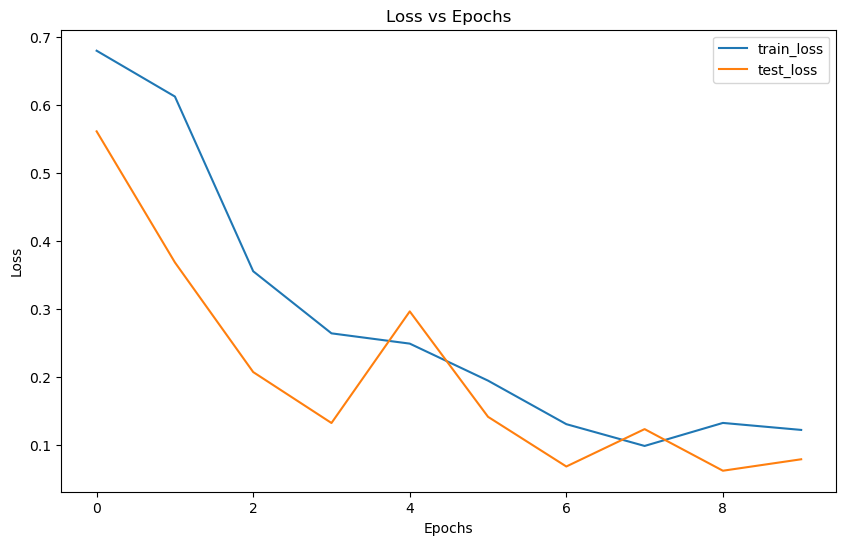

In [12]:
import matplotlib.pyplot as plt


def plot_loss_curve(results: dict[str, list[float]]):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    plt.title("Loss vs Epochs")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curve(model0_results)

In [13]:
# from Modules import Save_PyTorch_Models

# dummy_data = torch.rand([1, 2048])

# dummy_data.shape

# Save_PyTorch_Models.save(model0, "DILIst", dummy_data.to(device))

In [14]:
from Modules import PyTorch_Pretrained_Inference

validation_smiles = ["CCC", "CCCC", "Fc1ccc(cc1)[C@@]3(OCc2cc(C#N)ccc23)CCCN(C)C"]
validation_smiles_labels = [1, 0, 1]

regular_fingerprints = [
    "ecfp",
    "fcfp",
    "secfp",
]

PyTorch_Pretrained_Inference.DILI_Inference(validation_smiles, model0).regular_fingerprint(regular_fingerprints)

100%|██████████| 3/3 [00:00<00:00, 249.96it/s]


,Fingerprint type,CCC,CCCC,Fc1ccc(cc1)[C@@]3(OCc2cc(C#N)ccc23)CCCN(C)C
0,ecfp,0.871288,0.939998,1.0
1,fcfp,0.429680,0.708303,1.0
2,secfp,0.911357,0.869707,1.0


In [15]:
from Modules import Fingerprint_Comparator

Fingerprint_Comparator.PyTorch_Pretrained(validation_smiles, validation_smiles_labels, model0).regular_fingerprint(regular_fingerprints, 2048)

100%|██████████| 3/3 [00:00<00:00, 214.25it/s]


,Fingerprint type,acc
0,ecfp,0.666667
1,fcfp,0.333333
2,secfp,0.666667


In [16]:
# ## Assuming you have loaded_model and device available

# from Modules import Fingerprint_Generator

# validation_smiles = ["CCC", "CCCC", "Fc1ccc(cc1)[C@@]3(OCc2cc(C#N)ccc23)CCCN(C)C"]

# def evaluate_smiles(model, input_smiles):
#     scores = {}
#     validation_fp = Fingerprint_Generator.Smiles_To_Fingerprint(input_smiles, fingerprint).astype(torch.Tensor).squeeze(1).to(device)
#     with torch.no_grad():
#         model0.eval()
#         for i, input in enumerate(validation_fp):
#             output = model(input)
#             scores.update({round(output.item(), 3): validation_smiles[i]})
#             # scores.append(output.item())
#         return scores

# print(evaluate_smiles(model0, validation_smiles))


# # print(f"Prediction for {validation_smiles}: {prediction:.3f}")